In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

from chembl_webresource_client.new_client import new_client 

In [3]:
# Separate small molecule drugs based on progress through phases
all_mol = new_client.molecule
small_mol = all_mol.filter(molecule_type='Small molecule')
small_mol_phase1 = small_mol.filter(max_phase=1).filter(molecule_properties__full_mwt__gt=0).filter(
    molecule_properties__psa__gt=0).filter(molecule_properties__alogp__gt=0)
small_mol_phase2 = small_mol.filter(max_phase=2).filter(molecule_properties__full_mwt__gt=0).filter(
    molecule_properties__psa__gt=0).filter(molecule_properties__alogp__gt=0)
small_mol_phase3 = small_mol.filter(max_phase=3).filter(molecule_properties__full_mwt__gt=0).filter(
    molecule_properties__psa__gt=0).filter(molecule_properties__alogp__gt=0)
small_mol_phase4 = small_mol.filter(max_phase=4).filter(molecule_properties__full_mwt__gt=0).filter(
    molecule_properties__psa__gt=0).filter(molecule_properties__alogp__gt=0)

small_mol_phase1_len = len(small_mol_phase1)
small_mol_phase2_len = len(small_mol_phase2)
small_mol_phase3_len = len(small_mol_phase3)
small_mol_phase4_len = len(small_mol_phase4)

print(small_mol_phase1_len)
print(small_mol_phase2_len)
print(small_mol_phase3_len)
print(small_mol_phase4_len)

782
5706
828
2848


In [5]:
# Extract data from QuerySets. There probably is a better way to do this, but these Query 
# sets have limited functionality and only() does not allow nesting to get molecule properties

small_mol_phase1_MWT = np.zeros(small_mol_phase1_len)
small_mol_phase1_PSA = np.zeros(small_mol_phase1_len)
small_mol_phase1_alogp = np.zeros(small_mol_phase1_len)
for i in range(small_mol_phase1_len):
    MWT = small_mol_phase1[i]['molecule_properties']['full_mwt']
    PSA = small_mol_phase1[i]['molecule_properties']['psa']
    ALOGP = small_mol_phase1[i]['molecule_properties']['alogp']

    if MWT is not None:
        MWT = float(MWT)

    if PSA is not None:
        PSA = float(PSA)
    
    if ALOGP is not None:
        ALOGP = float(ALOGP)
    
    small_mol_phase1_MWT[i] = MWT
    small_mol_phase1_PSA[i] = PSA
    small_mol_phase1_alogp[i] = ALOGP


small_mol_phase2_MWT = np.zeros(small_mol_phase2_len)
small_mol_phase2_PSA = np.zeros(small_mol_phase2_len)
small_mol_phase2_alogp = np.zeros(small_mol_phase2_len)
for i in range(small_mol_phase2_len):
    MWT = small_mol_phase2[i]['molecule_properties']['full_mwt']
    PSA = small_mol_phase2[i]['molecule_properties']['psa']
    ALOGP = small_mol_phase2[i]['molecule_properties']['alogp']

    if MWT is not None:
        MWT = float(MWT)

    if PSA is not None:
        PSA = float(PSA)
    
    if ALOGP is not None:
        ALOGP = float(ALOGP)

    
    small_mol_phase2_MWT[i] = MWT
    small_mol_phase2_PSA[i] = PSA
    small_mol_phase2_alogp[i] = ALOGP


small_mol_phase3_MWT = np.zeros(small_mol_phase3_len)
small_mol_phase3_PSA = np.zeros(small_mol_phase3_len)
small_mol_phase3_alogp = np.zeros(small_mol_phase3_len)
for i in range(small_mol_phase3_len):
    MWT = small_mol_phase3[i]['molecule_properties']['full_mwt']
    PSA = small_mol_phase3[i]['molecule_properties']['psa']
    ALOGP = small_mol_phase3[i]['molecule_properties']['alogp']

    if MWT is not None:
        MWT = float(MWT)

    if PSA is not None:
        PSA = float(PSA)
    
    if ALOGP is not None:
        ALOGP = float(ALOGP)
    
    small_mol_phase3_MWT[i] = MWT
    small_mol_phase3_PSA[i] = PSA
    small_mol_phase3_alogp[i] = ALOGP

small_mol_phase4_MWT = np.zeros(small_mol_phase4_len)
small_mol_phase4_PSA = np.zeros(small_mol_phase4_len)
small_mol_phase4_alogp = np.zeros(small_mol_phase4_len)
for i in range(small_mol_phase1_len):
    MWT = small_mol_phase4[i]['molecule_properties']['full_mwt']
    PSA = small_mol_phase4[i]['molecule_properties']['psa']
    ALOGP = small_mol_phase4[i]['molecule_properties']['alogp']

    if MWT is not None:
        MWT = float(MWT)

    if PSA is not None:
        PSA = float(PSA)
    
    if ALOGP is not None:
        ALOGP = float(ALOGP)
    
    small_mol_phase4_MWT[i] = MWT
    small_mol_phase4_PSA[i] = PSA
    small_mol_phase4_alogp[i] = ALOGP

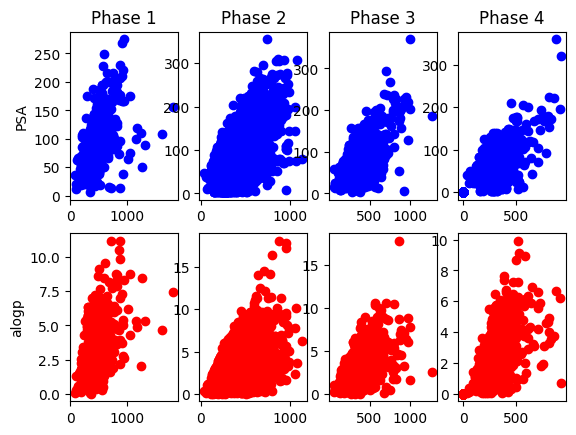

In [6]:
# Let's plot some properties
fig,ax = plt.subplots(2,4)
ax[0,0].set_title('Phase 1')
ax[0,0].set_ylabel('PSA')
ax[1,0].set_ylabel('alogp')
ax[0,0].scatter(small_mol_phase1_MWT,small_mol_phase1_PSA,color='b')
ax[1,0].scatter(small_mol_phase1_MWT,small_mol_phase1_alogp,color='r')
ax[0,1].set_title('Phase 2')
ax[0,1].scatter(small_mol_phase2_MWT,small_mol_phase2_PSA,color='b')
ax[1,1].scatter(small_mol_phase2_MWT,small_mol_phase2_alogp,color='r')
ax[0,2].set_title('Phase 3')
ax[0,2].scatter(small_mol_phase3_MWT,small_mol_phase3_PSA,color='b')
ax[1,2].scatter(small_mol_phase3_MWT,small_mol_phase3_alogp,color='r')
ax[0,3].set_title('Phase 4')
ax[0,3].scatter(small_mol_phase4_MWT,small_mol_phase4_PSA,color='b')
ax[1,3].scatter(small_mol_phase4_MWT,small_mol_phase4_alogp,color='r')


In [7]:
# Let's build some models - Linear Regression with and without ridge

def LinearModel(XDat,YDat,
           model,
           test_size=0.33,
           random_state=1):
    X_Train,X_Test,Y_Train,Y_Test = train_test_split(
        XDat,YDat,test_size=test_size,random_state=random_state)

    model.fit(X_Train,Y_Train)

    YHat = model.predict(X_Test)

    return (((Y_Test-YHat)**2).mean(),model.score(X_Test,Y_Test))

In [8]:
# Run Models for PSA    
LR_PSA_1_MSE, LR_PSA_1_R2 = LinearModel(small_mol_phase1_MWT.reshape(-1, 1),
                           small_mol_phase1_PSA,linear_model.LinearRegression(),random_state=1)
RR_PSA_1_MSE, RR_PSA_1_R2 = LinearModel(small_mol_phase1_MWT.reshape(-1, 1),
                           small_mol_phase1_PSA,linear_model.Ridge(alpha=1e3),random_state=11)

LR_PSA_2_MSE, LR_PSA_2_R2 = LinearModel(small_mol_phase2_MWT.reshape(-1, 1),
                           small_mol_phase2_PSA,linear_model.LinearRegression(),random_state=2)
RR_PSA_2_MSE, RR_PSA_2_R2 = LinearModel(small_mol_phase2_MWT.reshape(-1, 1),
                           small_mol_phase2_PSA,linear_model.Ridge(alpha=1e3),random_state=12)

LR_PSA_3_MSE, LR_PSA_3_R2 = LinearModel(small_mol_phase3_MWT.reshape(-1, 1),
                           small_mol_phase3_PSA,linear_model.LinearRegression(),random_state=3)
RR_PSA_3_MSE, RR_PSA_3_R2 = LinearModel(small_mol_phase3_MWT.reshape(-1, 1),
                           small_mol_phase3_PSA,linear_model.Ridge(alpha=1e3),random_state=13)

LR_PSA_4_MSE, LR_PSA_4_R2 = LinearModel(small_mol_phase4_MWT.reshape(-1, 1),
                           small_mol_phase4_PSA,linear_model.LinearRegression(),random_state=4)
RR_PSA_4_MSE, RR_PSA_4_R2 = LinearModel(small_mol_phase4_MWT.reshape(-1, 1),
                           small_mol_phase4_PSA,linear_model.Ridge(alpha=1e3),random_state=14)

print('LR MSE on Phase 1 Data is {0}. RR MSE on Phase 1 Data is {1}'.format(LR_PSA_1_MSE,RR_PSA_1_MSE))
print('LR MSE on Phase 2 Data is {0}. RR MSE on Phase 2 Data is {1}'.format(LR_PSA_2_MSE,RR_PSA_2_MSE))
print('LR MSE on Phase 3 Data is {0}. RR MSE on Phase 3 Data is {1}'.format(LR_PSA_3_MSE,RR_PSA_3_MSE))
print('LR MSE on Phase 4 Data is {0}. RR MSE on Phase 4 Data is {1}'.format(LR_PSA_4_MSE,RR_PSA_4_MSE))


print('LR R2 on Phase 1 Data is {0}. RR R2 on Phase 1 Data is {1}'.format(LR_PSA_1_R2,RR_PSA_1_R2))
print('LR R2 on Phase 2 Data is {0}. RR R2 on Phase 2 Data is {1}'.format(LR_PSA_2_R2,RR_PSA_2_R2))
print('LR R2 on Phase 3 Data is {0}. RR R2 on Phase 3 Data is {1}'.format(LR_PSA_3_R2,RR_PSA_3_R2))
print('LR R2 on Phase 4 Data is {0}. RR R2 on Phase 4 Data is {1}'.format(LR_PSA_4_R2,RR_PSA_4_R2))

LR MSE on Phase 1 Data is 1193.6739279649992. RR MSE on Phase 1 Data is 1257.0346724981325
LR MSE on Phase 2 Data is 1232.3042704883098. RR MSE on Phase 2 Data is 1197.5488398964787
LR MSE on Phase 3 Data is 1202.9273088135124. RR MSE on Phase 3 Data is 1080.314560565309
LR MSE on Phase 4 Data is 286.29381113399086. RR MSE on Phase 4 Data is 293.64182337214106
LR R2 on Phase 1 Data is 0.12826543731695816. RR R2 on Phase 1 Data is 0.21823793304121986
LR R2 on Phase 2 Data is 0.3353661662229731. RR R2 on Phase 2 Data is 0.3347664614866166
LR R2 on Phase 3 Data is 0.44087339394719527. RR R2 on Phase 3 Data is 0.4015132258195325
LR R2 on Phase 4 Data is 0.7546455755192382. RR R2 on Phase 4 Data is 0.7787861464412535


In [9]:
# Run Models for ALOGP    
LR_ALOGP_1_MSE, LR_ALOGP_1_R2 = LinearModel(small_mol_phase1_MWT.reshape(-1, 1),
                           small_mol_phase1_alogp,linear_model.LinearRegression(),random_state=1)
RR_ALOGP_1_MSE, RR_ALOGP_1_R2 = LinearModel(small_mol_phase1_MWT.reshape(-1, 1),
                           small_mol_phase1_alogp,linear_model.Ridge(alpha=1e3),random_state=11)

LR_ALOGP_2_MSE, LR_ALOGP_2_R2 = LinearModel(small_mol_phase2_MWT.reshape(-1, 1),
                           small_mol_phase2_alogp,linear_model.LinearRegression(),random_state=2)
RR_ALOGP_2_MSE, RR_ALOGP_2_R2 = LinearModel(small_mol_phase2_MWT.reshape(-1, 1),
                           small_mol_phase2_alogp,linear_model.Ridge(alpha=1e3),random_state=12)

LR_ALOGP_3_MSE, LR_ALOGP_3_R2 = LinearModel(small_mol_phase3_MWT.reshape(-1, 1),
                           small_mol_phase3_alogp,linear_model.LinearRegression(),random_state=3)
RR_ALOGP_3_MSE, RR_ALOGP_3_R2 = LinearModel(small_mol_phase3_MWT.reshape(-1, 1),
                           small_mol_phase3_alogp,linear_model.Ridge(alpha=1e3),random_state=13)

LR_ALOGP_4_MSE, LR_ALOGP_4_R2 = LinearModel(small_mol_phase4_MWT.reshape(-1, 1),
                           small_mol_phase4_alogp,linear_model.LinearRegression(),random_state=4)
RR_ALOGP_4_MSE, RR_ALOGP_4_R2 = LinearModel(small_mol_phase4_MWT.reshape(-1, 1),
                           small_mol_phase4_alogp,linear_model.Ridge(alpha=1e3),random_state=14)

print('LR MSE on Phase 1 Data is {0}. RR MSE on Phase 1 Data is {1}'.format(LR_ALOGP_1_MSE,RR_ALOGP_1_MSE))
print('LR MSE on Phase 2 Data is {0}. RR MSE on Phase 2 Data is {1}'.format(LR_ALOGP_2_MSE,RR_ALOGP_2_MSE))
print('LR MSE on Phase 3 Data is {0}. RR MSE on Phase 3 Data is {1}'.format(LR_ALOGP_3_MSE,RR_ALOGP_3_MSE))
print('LR MSE on Phase 4 Data is {0}. RR MSE on Phase 4 Data is {1}'.format(LR_ALOGP_4_MSE,RR_ALOGP_4_MSE))
print('LR R2 on Phase 1 Data is {0}. RR R2 on Phase 1 Data is {1}'.format(LR_ALOGP_1_R2,RR_ALOGP_1_R2))
print('LR R2 on Phase 2 Data is {0}. RR R2 on Phase 2 Data is {1}'.format(LR_ALOGP_2_R2,RR_ALOGP_2_R2))
print('LR R2 on Phase 3 Data is {0}. RR R2 on Phase 3 Data is {1}'.format(LR_ALOGP_3_R2,RR_ALOGP_3_R2))
print('LR R2 on Phase 4 Data is {0}. RR R2 on Phase 4 Data is {1}'.format(LR_ALOGP_4_R2,RR_ALOGP_4_R2))


LR MSE on Phase 1 Data is 2.527919104289665. RR MSE on Phase 1 Data is 2.652004072812948
LR MSE on Phase 2 Data is 2.4451874005984635. RR MSE on Phase 2 Data is 2.4049762157618058
LR MSE on Phase 3 Data is 2.809354347360042. RR MSE on Phase 3 Data is 2.511042176464181
LR MSE on Phase 4 Data is 0.48541903649910506. RR MSE on Phase 4 Data is 0.6313345263161804
LR R2 on Phase 1 Data is 0.2015765325885691. RR R2 on Phase 1 Data is 0.10297056275430949
LR R2 on Phase 2 Data is 0.2479515365090329. RR R2 on Phase 2 Data is 0.2408863820264331
LR R2 on Phase 3 Data is 0.2079182172056494. RR R2 on Phase 3 Data is 0.26537689927642993
LR R2 on Phase 4 Data is 0.7915398519375205. RR R2 on Phase 4 Data is 0.7482534014177902


In [10]:
# For fun, let's try a second order term:

# Run Models for PSA    
LR_PSA_1_MSE, LR_PSA_1_R2 = LinearModel(np.stack((small_mol_phase1_MWT,np.power(small_mol_phase1_MWT,2)),axis=1),
                           small_mol_phase1_PSA,linear_model.LinearRegression(),random_state=1)
RR_PSA_1_MSE, RR_PSA_1_R2 = LinearModel(np.stack((small_mol_phase1_MWT,np.power(small_mol_phase1_MWT,2)),axis=1),
                           small_mol_phase1_PSA,linear_model.Ridge(alpha=1e3),random_state=11)

LR_PSA_2_MSE, LR_PSA_2_R2 = LinearModel(np.stack((small_mol_phase2_MWT,np.power(small_mol_phase2_MWT,2)),axis=1),
                           small_mol_phase2_PSA,linear_model.LinearRegression(),random_state=2)
RR_PSA_2_MSE, RR_PSA_2_R2 = LinearModel(np.stack((small_mol_phase2_MWT,np.power(small_mol_phase2_MWT,2)),axis=1),
                           small_mol_phase2_PSA,linear_model.Ridge(alpha=1e3),random_state=12)

LR_PSA_3_MSE, LR_PSA_3_R2 = LinearModel(np.stack((small_mol_phase3_MWT,np.power(small_mol_phase3_MWT,2)),axis=1),
                           small_mol_phase3_PSA,linear_model.LinearRegression(),random_state=3)
RR_PSA_3_MSE, RR_PSA_3_R2 = LinearModel(np.stack((small_mol_phase3_MWT,np.power(small_mol_phase3_MWT,2)),axis=1),
                           small_mol_phase3_PSA,linear_model.Ridge(alpha=1e3),random_state=13)

LR_PSA_4_MSE, LR_PSA_4_R2 = LinearModel(np.stack((small_mol_phase4_MWT,np.power(small_mol_phase4_MWT,2)),axis=1),
                           small_mol_phase4_PSA,linear_model.LinearRegression(),random_state=4)
RR_PSA_4_MSE, RR_PSA_4_R2 = LinearModel(np.stack((small_mol_phase4_MWT,np.power(small_mol_phase4_MWT,2)),axis=1),
                           small_mol_phase4_PSA,linear_model.Ridge(alpha=1e3),random_state=14)

print('LR MSE on Phase 1 Data is {0}. RR MSE on Phase 1 Data is {1}'.format(LR_PSA_1_MSE,RR_PSA_1_MSE))
print('LR MSE on Phase 2 Data is {0}. RR MSE on Phase 2 Data is {1}'.format(LR_PSA_2_MSE,RR_PSA_2_MSE))
print('LR MSE on Phase 3 Data is {0}. RR MSE on Phase 3 Data is {1}'.format(LR_PSA_3_MSE,RR_PSA_3_MSE))
print('LR MSE on Phase 4 Data is {0}. RR MSE on Phase 4 Data is {1}'.format(LR_PSA_4_MSE,RR_PSA_4_MSE))


print('LR R2 on Phase 1 Data is {0}. RR R2 on Phase 1 Data is {1}'.format(LR_PSA_1_R2,RR_PSA_1_R2))
print('LR R2 on Phase 2 Data is {0}. RR R2 on Phase 2 Data is {1}'.format(LR_PSA_2_R2,RR_PSA_2_R2))
print('LR R2 on Phase 3 Data is {0}. RR R2 on Phase 3 Data is {1}'.format(LR_PSA_3_R2,RR_PSA_3_R2))
print('LR R2 on Phase 4 Data is {0}. RR R2 on Phase 4 Data is {1}'.format(LR_PSA_4_R2,RR_PSA_4_R2))


LR MSE on Phase 1 Data is 1041.2064862896177. RR MSE on Phase 1 Data is 1141.6277322643405
LR MSE on Phase 2 Data is 1233.3215876416823. RR MSE on Phase 2 Data is 1188.9468300388107
LR MSE on Phase 3 Data is 1208.9568909004768. RR MSE on Phase 3 Data is 1068.8747142767525
LR MSE on Phase 4 Data is 296.7796708488641. RR MSE on Phase 4 Data is 294.12772608763066
LR R2 on Phase 1 Data is 0.23961170657734188. RR R2 on Phase 1 Data is 0.2900106296202729
LR R2 on Phase 2 Data is 0.3348174840378946. RR R2 on Phase 2 Data is 0.3395448431820455
LR R2 on Phase 3 Data is 0.43807081415413496. RR R2 on Phase 3 Data is 0.4078508213239158
LR R2 on Phase 4 Data is 0.7456591707299127. RR R2 on Phase 4 Data is 0.7784200936395316


In [11]:
# Run Models for PSA    
LR_ALOGP_1_MSE, LR_ALOGP_1_R2 = LinearModel(np.stack((small_mol_phase1_MWT,np.power(small_mol_phase1_MWT,2)),axis=1),
                           small_mol_phase1_alogp,linear_model.LinearRegression(),random_state=1)
RR_ALOGP_1_MSE, RR_ALOGP_1_R2 = LinearModel(np.stack((small_mol_phase1_MWT,np.power(small_mol_phase1_MWT,2)),axis=1),
                           small_mol_phase1_alogp,linear_model.Ridge(alpha=1e3),random_state=11)

LR_ALOGP_2_MSE, LR_ALOGP_2_R2 = LinearModel(np.stack((small_mol_phase2_MWT,np.power(small_mol_phase2_MWT,2)),axis=1),
                           small_mol_phase2_alogp,linear_model.LinearRegression(),random_state=2)
RR_ALOGP_2_MSE, RR_ALOGP_2_R2 = LinearModel(np.stack((small_mol_phase2_MWT,np.power(small_mol_phase2_MWT,2)),axis=1),
                           small_mol_phase2_alogp,linear_model.Ridge(alpha=1e3),random_state=12)

LR_ALOGP_3_MSE, LR_ALOGP_3_R2 = LinearModel(np.stack((small_mol_phase3_MWT,np.power(small_mol_phase3_MWT,2)),axis=1),
                           small_mol_phase3_alogp,linear_model.LinearRegression(),random_state=3)
RR_ALOGP_3_MSE, RR_ALOGP_3_R2 = LinearModel(np.stack((small_mol_phase3_MWT,np.power(small_mol_phase3_MWT,2)),axis=1),
                           small_mol_phase3_alogp,linear_model.Ridge(alpha=1e3),random_state=13)

LR_ALOGP_4_MSE, LR_ALOGP_4_R2 = LinearModel(np.stack((small_mol_phase4_MWT,np.power(small_mol_phase4_MWT,2)),axis=1),
                           small_mol_phase4_alogp,linear_model.LinearRegression(),random_state=4)
RR_ALOGP_4_MSE, RR_ALOGP_4_R2 = LinearModel(np.stack((small_mol_phase4_MWT,np.power(small_mol_phase4_MWT,2)),axis=1),
                           small_mol_phase4_alogp,linear_model.Ridge(alpha=1e3),random_state=14)

print('LR MSE on Phase 1 Data is {0}. RR MSE on Phase 1 Data is {1}'.format(LR_ALOGP_1_MSE,RR_ALOGP_1_MSE))
print('LR MSE on Phase 2 Data is {0}. RR MSE on Phase 2 Data is {1}'.format(LR_ALOGP_2_MSE,RR_ALOGP_2_MSE))
print('LR MSE on Phase 3 Data is {0}. RR MSE on Phase 3 Data is {1}'.format(LR_ALOGP_3_MSE,RR_ALOGP_3_MSE))
print('LR MSE on Phase 4 Data is {0}. RR MSE on Phase 4 Data is {1}'.format(LR_ALOGP_4_MSE,RR_ALOGP_4_MSE))


print('LR R2 on Phase 1 Data is {0}. RR R2 on Phase 1 Data is {1}'.format(LR_ALOGP_1_R2,RR_ALOGP_1_R2))
print('LR R2 on Phase 2 Data is {0}. RR R2 on Phase 2 Data is {1}'.format(LR_ALOGP_2_R2,RR_ALOGP_2_R2))
print('LR R2 on Phase 3 Data is {0}. RR R2 on Phase 3 Data is {1}'.format(LR_ALOGP_3_R2,RR_ALOGP_3_R2))
print('LR R2 on Phase 4 Data is {0}. RR R2 on Phase 4 Data is {1}'.format(LR_ALOGP_4_R2,RR_ALOGP_4_R2))


LR MSE on Phase 1 Data is 2.392355815024748. RR MSE on Phase 1 Data is 2.5472704549615144
LR MSE on Phase 2 Data is 2.4205616754173285. RR MSE on Phase 2 Data is 2.3355551399189567
LR MSE on Phase 3 Data is 2.661658460535722. RR MSE on Phase 3 Data is 2.4421768684213734
LR MSE on Phase 4 Data is 0.48321002427907356. RR MSE on Phase 4 Data is 0.584502148047615
LR R2 on Phase 1 Data is 0.24439313668200113. RR R2 on Phase 1 Data is 0.1383962769321635
LR R2 on Phase 2 Data is 0.2555254912825161. RR R2 on Phase 2 Data is 0.2627986503063876
LR R2 on Phase 3 Data is 0.2495602483923287. RR R2 on Phase 3 Data is 0.2855239308957582
LR R2 on Phase 4 Data is 0.7924884983230861. RR R2 on Phase 4 Data is 0.7669279573642556


In [151]:
# let's try a NN now!
# PrepareData

def NNDataPrep(XDat,YDat,
                test_size=0.33,
                random_state=1):
    scaler = StandardScaler(with_mean=True,with_std=True)
    scaler.fit(XDat.reshape(-1, 1))
    XDatS = scaler.transform(XDat.reshape(-1, 1))
    
    X_Train,X_Test,Y_Train,Y_Test = train_test_split(
        XDatS,YDat,test_size=test_size,random_state=random_state)
    
    X_train_T = torch.tensor(X_Train.astype(np.float32))

    Train_Dat = TensorDataset(X_train_T,
        torch.tensor(Y_Train.astype(np.float32)))
    
    X_Test_T = torch.tensor(X_Test.astype(np.float32))   
    Test_Dat = TensorDataset(X_Test_T,
        torch.tensor(Y_Test.astype(np.float32)))
    return (Train_Dat,Test_Dat)

In [121]:
PSA1_Train, PSA1_Test = NNDataPrep(small_mol_phase1_MWT,small_mol_phase1_PSA,
                                    test_size=0.2,random_state=1)

625
torch.Size([625, 1])


In [152]:
PSA1_Train, PSA1_Test = NNDataPrep(small_mol_phase1_MWT,small_mol_phase1_PSA,
                                    test_size=0.2,random_state=1)
PSA2_Train, PSA2_Test = NNDataPrep(small_mol_phase2_MWT,small_mol_phase2_PSA,
                                    test_size=0.2,random_state=1)
PSA3_Train, PSA3_Test = NNDataPrep(small_mol_phase3_MWT,small_mol_phase3_PSA,
                                    test_size=0.2,random_state=1)
PSA4_Train, PSA4_Test = NNDataPrep(small_mol_phase4_MWT,small_mol_phase4_PSA,
                                    test_size=0.2,random_state=1)

ALOGP1_Train, ALOGP1_Test = NNDataPrep(small_mol_phase1_MWT,small_mol_phase1_alogp,
                                    test_size=0.2,random_state=1)
ALOGP2_Train, ALOGP2_Test = NNDataPrep(small_mol_phase2_MWT,small_mol_phase2_alogp,
                                    test_size=0.2,random_state=1)
ALOGP3_Train, ALOGP3_Test = NNDataPrep(small_mol_phase3_MWT,small_mol_phase3_alogp,
                                    test_size=0.2,random_state=1)
ALOGP4_Train, ALOGP4_Test = NNDataPrep(small_mol_phase4_MWT,small_mol_phase4_alogp,
                                    test_size=0.2,random_state=1)



In [172]:
# Set up class

class Neural(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.nn_stack = nn.Sequential(
            nn.Linear(1,512), #Testing numbers here
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,1))

    def forward(self,x):
        x = self.flatten(x)
        return self.nn_stack(x)

In [173]:
# Hyperparameters, not tuning atm
learning_rate = 1e-3
batch_size = 64
epochs=30

# Loss function
loss_fn = nn.MSELoss()

In [174]:
PSA1_model = Neural()
PSA1_optimizer = torch.optim.SGD(PSA1_model.parameters(),lr=learning_rate)
PSA1_Train_dl = DataLoader(PSA1_Train,batch_size=batch_size)
PSA1_Test_dl = DataLoader(PSA1_Test,batch_size=batch_size)

PSA2_model = Neural()
PSA2_optimizer = torch.optim.SGD(PSA2_model.parameters(),lr=learning_rate)
PSA2_Train_dl = DataLoader(PSA2_Train,batch_size=batch_size)
PSA2_Test_dl = DataLoader(PSA2_Test,batch_size=batch_size)

PSA3_model = Neural()
PSA3_optimizer = torch.optim.SGD(PSA3_model.parameters(),lr=learning_rate)
PSA3_Train_dl = DataLoader(PSA3_Train,batch_size=batch_size)
PSA3_Test_dl = DataLoader(PSA3_Test,batch_size=batch_size)

PSA4_model = Neural()
PSA4_optimizer = torch.optim.SGD(PSA4_model.parameters(),lr=learning_rate)
PSA4_Train_dl = DataLoader(PSA1_Train,batch_size=batch_size)
PSA4_Test_dl = DataLoader(PSA1_Test,batch_size=batch_size)


In [239]:
ALOGP1_model = Neural()
ALOGP1_optimizer = torch.optim.SGD(ALOGP1_model.parameters(),lr=learning_rate)
ALOGP1_Train_dl = DataLoader(ALOGP1_Train,batch_size=batch_size)
ALOGP1_Test_dl = DataLoader(ALOGP1_Test,batch_size=batch_size)

ALOGP2_model = Neural()
ALOGP2_optimizer = torch.optim.SGD(ALOGP2_model.parameters(),lr=learning_rate)
ALOGP2_Train_dl = DataLoader(ALOGP2_Train,batch_size=batch_size)
ALOGP2_Test_dl = DataLoader(ALOGP2_Test,batch_size=batch_size)

ALOGP3_model = Neural()
ALOGP3_optimizer = torch.optim.SGD(ALOGP3_model.parameters(),lr=learning_rate)
ALOGP3_Train_dl = DataLoader(ALOGP3_Train,batch_size=batch_size)
ALOGP3_Test_dl = DataLoader(ALOGP3_Test,batch_size=batch_size)

ALOGP4_model = Neural()
ALOGP4_optimizer = torch.optim.SGD(ALOGP4_model.parameters(),lr=learning_rate)
ALOGP4_Train_dl = DataLoader(ALOGP1_Train,batch_size=batch_size)
ALOGP4_Test_dl = DataLoader(ALOGP1_Test,batch_size=batch_size)

In [240]:
summary(PSA1_model)

Layer (type:depth-idx)                   Param #
Neural                                   --
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       1,024
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       262,656
│    └─ReLU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       513
Total params: 264,193
Trainable params: 264,193
Non-trainable params: 0

In [241]:
# Training and Validation Loops
def train_loop(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,Y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred,Y.unsqueeze(1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader,model,loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0

    with torch.no_grad():
        for X,Y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, Y.unsqueeze(1)).item()
    test_loss /= num_batches        
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
        

In [242]:
for tPSA1 in range(epochs):
    print(f"Epoch {tPSA1+1}\n-------------------------------")
    train_loop(PSA1_Train_dl,PSA1_model,loss_fn,PSA1_optimizer)
    test_loop(PSA1_Train_dl,PSA1_model,loss_fn)

for tPSA2 in range(epochs):
    print(f"Epoch {tPSA2+1}\n-------------------------------")
    train_loop(PSA2_Train_dl,PSA2_model,loss_fn,PSA2_optimizer)
    test_loop(PSA2_Train_dl,PSA2_model,loss_fn)

for tPSA3 in range(epochs):
    print(f"Epoch {tPSA3+1}\n-------------------------------")
    train_loop(PSA3_Train_dl,PSA3_model,loss_fn,PSA3_optimizer)
    test_loop(PSA3_Train_dl,PSA3_model,loss_fn)

for tPSA4 in range(epochs):
    print(f"Epoch {tPSA4+1}\n-------------------------------")
    train_loop(PSA4_Train_dl,PSA4_model,loss_fn,PSA4_optimizer)
    test_loop(PSA4_Train_dl,PSA4_model,loss_fn)    

Epoch 1
-------------------------------
loss: 1063.620850  [   64/  625]
Test Error: 
 Avg loss: 1036.337683 

Epoch 2
-------------------------------
loss: 911.122559  [   64/  625]
Test Error: 
 Avg loss: 1040.002893 

Epoch 3
-------------------------------
loss: 828.079529  [   64/  625]
Test Error: 
 Avg loss: 1048.030579 

Epoch 4
-------------------------------
loss: 1054.871826  [   64/  625]
Test Error: 
 Avg loss: 1040.352112 

Epoch 5
-------------------------------
loss: 949.332458  [   64/  625]
Test Error: 
 Avg loss: 1062.095111 

Epoch 6
-------------------------------
loss: 918.432434  [   64/  625]
Test Error: 
 Avg loss: 1039.814832 

Epoch 7
-------------------------------
loss: 771.519531  [   64/  625]
Test Error: 
 Avg loss: 1052.546228 

Epoch 8
-------------------------------
loss: 932.074158  [   64/  625]
Test Error: 
 Avg loss: 1039.483960 

Epoch 9
-------------------------------
loss: 989.908691  [   64/  625]
Test Error: 
 Avg loss: 1043.811731 

Epoch 10

In [243]:
for tALOGP1 in range(epochs):
    print(f"Epoch {tALOGP1+1}\n-------------------------------")
    train_loop(ALOGP1_Train_dl,ALOGP1_model,loss_fn,ALOGP1_optimizer)
    test_loop(ALOGP1_Train_dl,ALOGP1_model,loss_fn)

for tALOGP2 in range(epochs):
    print(f"Epoch {tALOGP2+1}\n-------------------------------")
    train_loop(ALOGP2_Train_dl,ALOGP2_model,loss_fn,ALOGP2_optimizer)
    test_loop(ALOGP2_Train_dl,ALOGP2_model,loss_fn)    

for tALOGP3 in range(epochs):
    print(f"Epoch {tALOGP3+1}\n-------------------------------")
    train_loop(ALOGP3_Train_dl,ALOGP3_model,loss_fn,ALOGP3_optimizer)
    test_loop(ALOGP3_Train_dl,ALOGP3_model,loss_fn)    

for tALOGP4 in range(epochs):
    print(f"Epoch {tALOGP4+1}\n-------------------------------")
    train_loop(ALOGP4_Train_dl,ALOGP4_model,loss_fn,ALOGP4_optimizer)
    test_loop(ALOGP4_Train_dl,ALOGP4_model,loss_fn)    

Epoch 1
-------------------------------
loss: 14.654198  [   64/  625]
Test Error: 
 Avg loss: 6.130959 

Epoch 2
-------------------------------
loss: 4.978293  [   64/  625]
Test Error: 
 Avg loss: 3.439774 

Epoch 3
-------------------------------
loss: 3.665694  [   64/  625]
Test Error: 
 Avg loss: 3.092090 

Epoch 4
-------------------------------
loss: 3.789220  [   64/  625]
Test Error: 
 Avg loss: 2.983883 

Epoch 5
-------------------------------
loss: 3.606340  [   64/  625]
Test Error: 
 Avg loss: 2.900942 

Epoch 6
-------------------------------
loss: 3.331438  [   64/  625]
Test Error: 
 Avg loss: 2.813599 

Epoch 7
-------------------------------
loss: 3.412224  [   64/  625]
Test Error: 
 Avg loss: 2.751332 

Epoch 8
-------------------------------
loss: 3.215496  [   64/  625]
Test Error: 
 Avg loss: 2.694576 

Epoch 9
-------------------------------
loss: 2.826317  [   64/  625]
Test Error: 
 Avg loss: 2.646193 

Epoch 10
-------------------------------
loss: 2.96996

In [254]:
# Let's plot comparisons

PSA1_model.eval()
PSA1_PredX = PSA1_Train_dl.dataset[:][0]
PSA1_PredY = PSA1_model(PSA1_PredX).detach().numpy()
PSA1_PredX = PSA1_PredX.detach().numpy()
PSA1_PlotX = [PSA1_Train_dl.dataset[i][0] for i in range(len(PSA1_Train_dl))]
PSA1_PlotY = [PSA1_Train_dl.dataset[i][1] for i in range(len(PSA1_Train_dl))]

PSA2_model.eval()
PSA2_PredX = PSA2_Train_dl.dataset[:][0]
PSA2_PredY = PSA2_model(PSA2_PredX).detach().numpy()
PSA2_PredX = PSA2_PredX.detach().numpy()
PSA2_PlotX = [PSA2_Train_dl.dataset[i][0] for i in range(len(PSA2_Train_dl))]
PSA2_PlotY = [PSA2_Train_dl.dataset[i][1] for i in range(len(PSA2_Train_dl))]

PSA3_model.eval()
PSA3_PredX = PSA3_Train_dl.dataset[:][0]
PSA3_PredY = PSA3_model(PSA3_PredX).detach().numpy()
PSA3_PredX = PSA3_PredX.detach().numpy()
PSA3_PlotX = [PSA3_Train_dl.dataset[i][0] for i in range(len(PSA3_Train_dl))]
PSA3_PlotY = [PSA3_Train_dl.dataset[i][1] for i in range(len(PSA3_Train_dl))]

PSA4_model.eval()
PSA4_PredX = PSA4_Train_dl.dataset[:][0]
PSA4_PredY = PSA4_model(PSA4_PredX).detach().numpy()
PSA4_PredX = PSA4_PredX.detach().numpy()
PSA4_PlotX = [PSA4_Train_dl.dataset[i][0] for i in range(len(PSA4_Train_dl))]
PSA4_PlotY = [PSA4_Train_dl.dataset[i][1] for i in range(len(PSA4_Train_dl))]

ALOGP1_model.eval()
ALOGP1_PredX = ALOGP1_Train_dl.dataset[:][0]
ALOGP1_PredY = ALOGP1_model(ALOGP1_PredX).detach().numpy()
ALOGP1_PredX = ALOGP1_PredX.detach().numpy()
ALOGP1_PlotX = [ALOGP1_Train_dl.dataset[i][0] for i in range(len(ALOGP1_Train_dl))]
ALOGP1_PlotY = [ALOGP1_Train_dl.dataset[i][1] for i in range(len(ALOGP1_Train_dl))]

ALOGP2_model.eval()
ALOGP2_PredX = ALOGP2_Train_dl.dataset[:][0]
ALOGP2_PredY = ALOGP2_model(ALOGP2_PredX).detach().numpy()
ALOGP2_PredX = ALOGP2_PredX.detach().numpy()
ALOGP2_PlotX = [ALOGP2_Train_dl.dataset[i][0] for i in range(len(ALOGP2_Train_dl))]
ALOGP2_PlotY = [ALOGP2_Train_dl.dataset[i][1] for i in range(len(ALOGP2_Train_dl))]

ALOGP3_model.eval()
ALOGP3_PredX = ALOGP3_Train_dl.dataset[:][0]
ALOGP3_PredY = ALOGP3_model(ALOGP3_PredX).detach().numpy()
ALOGP3_PredX = ALOGP3_PredX.detach().numpy()
ALOGP3_PlotX = [ALOGP3_Train_dl.dataset[i][0] for i in range(len(ALOGP3_Train_dl))]
ALOGP3_PlotY = [ALOGP3_Train_dl.dataset[i][1] for i in range(len(ALOGP3_Train_dl))]

ALOGP4_model.eval()
ALOGP4_PredX = ALOGP4_Train_dl.dataset[:][0]
ALOGP4_PredY = ALOGP4_model(ALOGP4_PredX).detach().numpy()
ALOGP4_PredX = ALOGP4_PredX.detach().numpy()
ALOGP4_PlotX = [ALOGP4_Train_dl.dataset[i][0] for i in range(len(ALOGP4_Train_dl))]
ALOGP4_PlotY = [ALOGP4_Train_dl.dataset[i][1] for i in range(len(ALOGP4_Train_dl))]

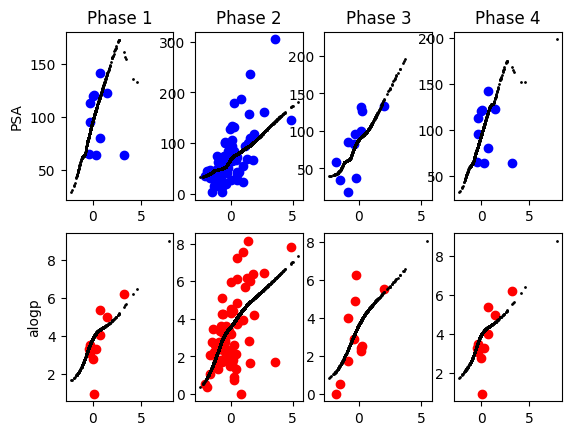

In [255]:
# Let's plot some properties
fig,ax = plt.subplots(2,4)
ax[0,0].set_title('Phase 1')
ax[0,0].set_ylabel('PSA')
ax[1,0].set_ylabel('alogp')
ax[0,0].scatter(PSA1_PlotX,PSA1_PlotY,color='b')
ax[0,0].scatter(PSA1_PredX,PSA1_PredY,color='k',s=1)
ax[1,0].scatter(ALOGP1_PlotX,ALOGP1_PlotY,color='r')
ax[1,0].scatter(ALOGP1_PredX,ALOGP1_PredY,color='k',s=1)
ax[0,1].set_title('Phase 2')
ax[0,1].scatter(PSA2_PlotX,PSA2_PlotY,color='b')
ax[0,1].scatter(PSA2_PredX,PSA2_PredY,color='k',s=1)
ax[1,1].scatter(ALOGP2_PlotX,ALOGP2_PlotY,color='r')
ax[1,1].scatter(ALOGP2_PredX,ALOGP2_PredY,color='k',s=1)
ax[0,2].set_title('Phase 3')
ax[0,2].scatter(PSA3_PlotX,PSA3_PlotY,color='b')
ax[0,2].scatter(PSA3_PredX,PSA3_PredY,color='k',s=1)
ax[1,2].scatter(ALOGP3_PlotX,ALOGP3_PlotY,color='r')
ax[1,2].scatter(ALOGP3_PredX,ALOGP3_PredY,color='k',s=1)
ax[0,3].set_title('Phase 4')
ax[0,3].scatter(PSA4_PlotX,PSA4_PlotY,color='b')
ax[0,3].scatter(PSA4_PredX,PSA4_PredY,color='k',s=1)
ax[1,3].scatter(ALOGP4_PlotX,ALOGP4_PlotY,color='r')
ax[1,3].scatter(ALOGP4_PredX,ALOGP4_PredY,color='k',s=1)


In [256]:
# Compare on validation set
PSA1_model.eval()
PSA1_PredX = PSA1_Test_dl.dataset[:][0]
PSA1_PredY = PSA1_model(PSA1_PredX).detach().numpy()
PSA1_PredX = PSA1_PredX.detach().numpy()
PSA1_PlotX = [PSA1_Test_dl.dataset[i][0] for i in range(len(PSA1_Test_dl))]
PSA1_PlotY = [PSA1_Test_dl.dataset[i][1] for i in range(len(PSA1_Test_dl))]

PSA2_model.eval()
PSA2_PredX = PSA2_Test_dl.dataset[:][0]
PSA2_PredY = PSA2_model(PSA2_PredX).detach().numpy()
PSA2_PredX = PSA2_PredX.detach().numpy()
PSA2_PlotX = [PSA2_Test_dl.dataset[i][0] for i in range(len(PSA2_Test_dl))]
PSA2_PlotY = [PSA2_Test_dl.dataset[i][1] for i in range(len(PSA2_Test_dl))]

PSA3_model.eval()
PSA3_PredX = PSA3_Test_dl.dataset[:][0]
PSA3_PredY = PSA3_model(PSA3_PredX).detach().numpy()
PSA3_PredX = PSA3_PredX.detach().numpy()
PSA3_PlotX = [PSA3_Test_dl.dataset[i][0] for i in range(len(PSA3_Test_dl))]
PSA3_PlotY = [PSA3_Test_dl.dataset[i][1] for i in range(len(PSA3_Test_dl))]

PSA4_model.eval()
PSA4_PredX = PSA4_Test_dl.dataset[:][0]
PSA4_PredY = PSA4_model(PSA4_PredX).detach().numpy()
PSA4_PredX = PSA4_PredX.detach().numpy()
PSA4_PlotX = [PSA4_Test_dl.dataset[i][0] for i in range(len(PSA4_Test_dl))]
PSA4_PlotY = [PSA4_Test_dl.dataset[i][1] for i in range(len(PSA4_Test_dl))]

ALOGP1_model.eval()
ALOGP1_PredX = ALOGP1_Test_dl.dataset[:][0]
ALOGP1_PredY = ALOGP1_model(ALOGP1_PredX).detach().numpy()
ALOGP1_PredX = ALOGP1_PredX.detach().numpy()
ALOGP1_PlotX = [ALOGP1_Test_dl.dataset[i][0] for i in range(len(ALOGP1_Test_dl))]
ALOGP1_PlotY = [ALOGP1_Test_dl.dataset[i][1] for i in range(len(ALOGP1_Test_dl))]

ALOGP2_model.eval()
ALOGP2_PredX = ALOGP2_Test_dl.dataset[:][0]
ALOGP2_PredY = ALOGP2_model(ALOGP2_PredX).detach().numpy()
ALOGP2_PredX = ALOGP2_PredX.detach().numpy()
ALOGP2_PlotX = [ALOGP2_Test_dl.dataset[i][0] for i in range(len(ALOGP2_Test_dl))]
ALOGP2_PlotY = [ALOGP2_Test_dl.dataset[i][1] for i in range(len(ALOGP2_Test_dl))]

ALOGP3_model.eval()
ALOGP3_PredX = ALOGP3_Test_dl.dataset[:][0]
ALOGP3_PredY = ALOGP3_model(ALOGP3_PredX).detach().numpy()
ALOGP3_PredX = ALOGP3_PredX.detach().numpy()
ALOGP3_PlotX = [ALOGP3_Test_dl.dataset[i][0] for i in range(len(ALOGP3_Test_dl))]
ALOGP3_PlotY = [ALOGP3_Test_dl.dataset[i][1] for i in range(len(ALOGP3_Test_dl))]

ALOGP4_model.eval()
ALOGP4_PredX = ALOGP4_Test_dl.dataset[:][0]
ALOGP4_PredY = ALOGP4_model(ALOGP4_PredX).detach().numpy()
ALOGP4_PredX = ALOGP4_PredX.detach().numpy()
ALOGP4_PlotX = [ALOGP4_Test_dl.dataset[i][0] for i in range(len(ALOGP4_Test_dl))]
ALOGP4_PlotY = [ALOGP4_Test_dl.dataset[i][1] for i in range(len(ALOGP4_Test_dl))]

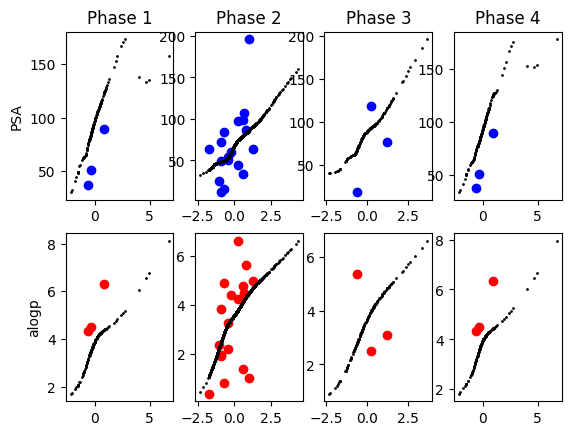

In [257]:
# Let's plot some properties
fig,ax = plt.subplots(2,4)
ax[0,0].set_title('Phase 1')
ax[0,0].set_ylabel('PSA')
ax[1,0].set_ylabel('alogp')
ax[0,0].scatter(PSA1_PlotX,PSA1_PlotY,color='b')
ax[0,0].scatter(PSA1_PredX,PSA1_PredY,color='k',s=1)
ax[1,0].scatter(ALOGP1_PlotX,ALOGP1_PlotY,color='r')
ax[1,0].scatter(ALOGP1_PredX,ALOGP1_PredY,color='k',s=1)
ax[0,1].set_title('Phase 2')
ax[0,1].scatter(PSA2_PlotX,PSA2_PlotY,color='b')
ax[0,1].scatter(PSA2_PredX,PSA2_PredY,color='k',s=1)
ax[1,1].scatter(ALOGP2_PlotX,ALOGP2_PlotY,color='r')
ax[1,1].scatter(ALOGP2_PredX,ALOGP2_PredY,color='k',s=1)
ax[0,2].set_title('Phase 3')
ax[0,2].scatter(PSA3_PlotX,PSA3_PlotY,color='b')
ax[0,2].scatter(PSA3_PredX,PSA3_PredY,color='k',s=1)
ax[1,2].scatter(ALOGP3_PlotX,ALOGP3_PlotY,color='r')
ax[1,2].scatter(ALOGP3_PredX,ALOGP3_PredY,color='k',s=1)
ax[0,3].set_title('Phase 4')
ax[0,3].scatter(PSA4_PlotX,PSA4_PlotY,color='b')
ax[0,3].scatter(PSA4_PredX,PSA4_PredY,color='k',s=1)
ax[1,3].scatter(ALOGP4_PlotX,ALOGP4_PlotY,color='r')
ax[1,3].scatter(ALOGP4_PredX,ALOGP4_PredY,color='k',s=1)
